In [1]:
import numpy as np
from scipy import stats, optimize
import matplotlib.pyplot as plt
np.random.seed(123)

$$\frac{\partial C}{\partial t} - \mathcal{D}\left( \frac{\partial^2 C}{\partial r^2} + \frac{2}{r}\frac{\partial C}{\partial r}\right) = 0$$

$$\gamma(t) = \frac{C(t,R)}{C(0,R)} = \frac{\alpha}{1 + \alpha} + 6 \alpha \sum\limits_{i=1}^\infty \frac{\exp \left(-\mathcal{D}\frac{q_n^2 t}{R^2}\right)}{9(\alpha + 1) + \alpha^2q_n^2}$$

$$\alpha = \frac{V_l}{V_s K_p}$$

$$\forall q_n \in \mathbb{R}^+_0 \, | \, \tan(q_n) = \frac{3 q_n}{3 + \alpha q_n^2} $$

In [2]:
class Solver:
    
    def __init__(self, alpha):
        self.alpha = alpha
        self.roots = {}
        
    def lhs(self, x):
        return np.tan(x)
    
    def rhs(self, x):
        return 3*x/(3 + self.alpha*x**2)

    def interval(self, n):
        return (-np.pi/2 + n*np.pi, np.pi/2 + n*np.pi)
    
    def objective(self, x):
        return (self.lhs(x) - self.rhs(x))**2

    def root(self, n):
        if n not in self.roots:
            result = optimize.minimize_scalar(
                self.objective,
                method="bounded",
                bounds=self.interval(n)
            )
            self.roots[n] = result.x
        return self.roots[n]
    
    def compute(self, n):
        solutions = []
        for i in range(n):
            solutions.append(self.root(i + 1))
        return np.array(solutions)

In [3]:
handler = Solver(3)

In [4]:
xlin = np.linspace(-4*np.pi, 10*np.pi, 5000)

In [5]:
xr = handler.compute(10)

In [6]:
xr

array([ 3.40560956,  6.43379729,  9.52821635, 12.64480217, 15.77103322,
       18.90226315, 22.03640253, 25.17238551, 28.30960007, 31.44768341])

In [7]:
lhs = handler.lhs(xlin)
q = np.where(np.diff(lhs) < 0)[0]
lhs[q] = np.nan

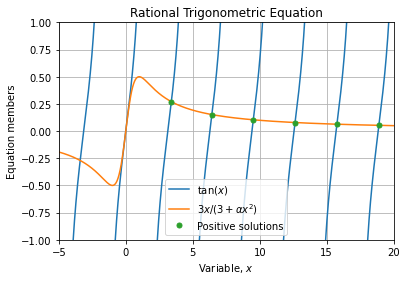

In [8]:
fig, axe = plt.subplots()
axe.plot(xlin, lhs, label=r"$\tan(x)$")
axe.plot(xlin, handler.rhs(xlin), label=r"$3 x / (3 + \alpha x^2)$")
axe.plot(xr, handler.rhs(xr), ".", markersize=10, label="Positive solutions")
axe.set_xlim([-5, 20])
axe.set_ylim([-1, 1])
axe.set_title("Rational Trigonometric Equation")
axe.set_xlabel(r"Variable, $x$")
axe.set_ylabel(r"Equation members")
axe.legend()
axe.grid()

In [7]:
class CrankDiffusion:
    
    def __init__(self, alpha=3, radius=1.9e-3, n=45):
        self.n = n
        self.alpha = alpha
        self.radius = radius
        self.objective = np.vectorize(self._objective, excluded='self')
    
    def alpha_prime(self, Kp):
        return self.alpha/Kp
    
    def solutions(self, Kp):
        return Solver(self.alpha_prime(Kp)).compute(self.n)
    
    def term(self, t, qn, Kp, D):
        return np.exp(-(D*t*qn**2)/(self.radius**2))/(9*(self.alpha_prime(Kp) + 1) + (self.alpha_prime(Kp)**2)*qn**2)
    
    def sum(self, t, Kp, D):
        return np.sum([self.term(t, qn, Kp, D) for qn in self.solutions(Kp)])
    
    def _objective(self, t, Kp, D):
        return self.alpha_prime(Kp)/(1 + self.alpha_prime(Kp)) + 6*self.alpha_prime(Kp)*self.sum(t, Kp, D)
        

In [10]:
S = CrankDiffusion(n=50)

In [11]:
tlin = np.logspace(0, 6, 100)

In [12]:
ratio = S.objective(tlin, 3.9, 2e-11)

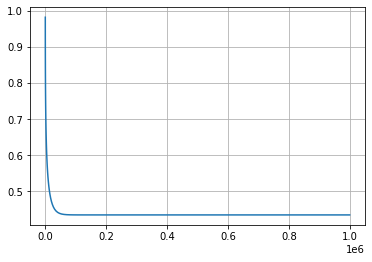

In [13]:
fig, axe = plt.subplots()
axe.plot(tlin, ratio)
axe.grid()

In [11]:
S.objective(0, 3.9, 2e-11)

array(0.98435807)

In [12]:
texp = np.logspace(0, 6, 20)
rexp = S.objective(texp, 3.9, 2e-11) + np.random.randn(texp.size)*0.005

In [13]:
parameters, covariance = optimize.curve_fit(S.objective, texp, rexp, (5, 1e-10))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()


In [14]:
parameters, covariance

(array([3.82213761e+00, 2.12189407e-11]),
 array([[ 1.56927242e-03, -2.23479865e-14],
        [-2.23479865e-14,  6.00514511e-25]]))

In [18]:
rfit = S.objective(tlin, *parameters)

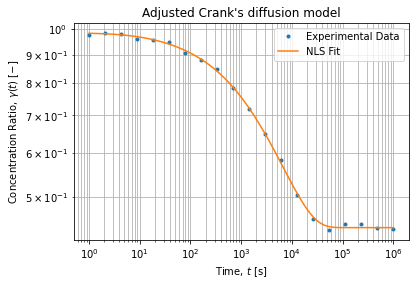

In [19]:
fig, axe = plt.subplots()
axe.loglog(texp, rexp, ".", label="Experimental Data")
axe.loglog(tlin, rfit, label="NLS Fit")
axe.set_title("Adjusted Crank's diffusion model")
axe.set_xlabel(r"Time, $t$ $[\mathrm{s}]$")
axe.set_ylabel(r"Concentration Ratio, $\gamma(t)$ $[-]$")
axe.legend()
axe.grid(which="both")

In [20]:
1.96*np.sqrt(1.57599053e-03)

0.07780954453052659

In [21]:
S0 = CrankDiffusion(n=5000)

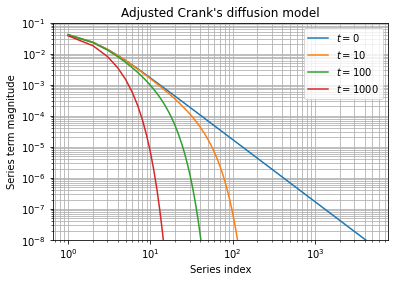

In [22]:
fig, axe = plt.subplots()
for t in [0, 10, 100, 1000]:
    terms = [S0.term(t, s, 3.9, 2e-11) for s in S0.solutions(3.9)]
    axe.loglog(np.arange(len(terms)) + 1, terms, label=r"$t=%d$" % t)
axe.set_title("Adjusted Crank's diffusion model")
axe.set_xlabel("Series index")
axe.set_ylabel("Series term magnitude")
axe.legend()
axe.set_ylim([1e-8, 1e-1])
axe.grid(which="both")

In [23]:
1e6/(60*60*24)

11.574074074074074

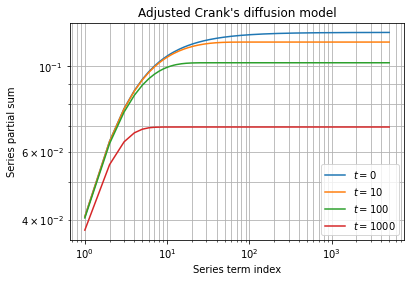

In [24]:
fig, axe = plt.subplots()
for t in [0, 10, 100, 1000]:
    terms = np.cumsum([S0.term(t, s, 3.9, 2e-11) for s in S0.solutions(3.9)])
    axe.loglog(np.arange(len(terms)) + 1, terms, label=r"$t=%d$" % t)
axe.set_title("Adjusted Crank's diffusion model")
axe.set_xlabel("Series term index")
axe.set_ylabel("Series partial sum")
axe.legend()
axe.grid(which="both")
#axe.set_ylim([1e-6, 1e-1])

In [25]:
np.cumsum([S0.term(0, s, 3.9, 2e-11) for s in S0.solutions(3.9)])

array([0.04072224, 0.06394964, 0.07771623, ..., 0.12242951, 0.12242951,
       0.12242952])

In [26]:
4/(1+4) + 6*4*0.121

3.7039999999999997

In [27]:
sum([S0.term(0, s, 3.9, 2e-11) for s in S0.solutions(3.9)])

0.12242952171381837

In [28]:
a = 3/3.9
6*a*0.12242952171381837 + (a/(1+a))

0.9998419396825062

In [29]:
S0.sum(0, 3.9, 2e-11)

0.12242952171381861

In [53]:
n = np.array([1] + list(range(2, 25, 1)) + list(range(25, 50, 5)) + list(range(50, 201, 25)))
n

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  30,
        35,  40,  45,  50,  75, 100, 125, 150, 175, 200])

In [54]:
import time

In [55]:
results = {}
for i in n:
    S1 = CrankDiffusion(n=i)
    tic = time.time()
    parameters, covariance = optimize.curve_fit(S1.objective, texp, rexp, (5, 1e-10))
    toc = time.time()
    results[i] = {"parameters": parameters, "covariance": covariance, "time": toc-tic}

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()


In [72]:
import pickle
with open("results.pickle", "wb") as handler:
    pickle.dump(results, handler)

In [56]:
Kps = np.array([results[i]["parameters"][0] for i in n])
sKps = np.array([np.sqrt(results[i]["covariance"][0][0]) for i in n])
ts = np.array([np.sqrt(results[i]["time"]) for i in n])
Ds = np.array([results[i]["parameters"][1] for i in n])
sDs = np.array([np.sqrt(results[i]["covariance"][1][1]) for i in n])

In [57]:
n

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  30,
        35,  40,  45,  50,  75, 100, 125, 150, 175, 200])

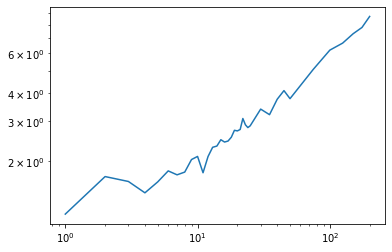

In [73]:
fig, axe = plt.subplots()
axe.loglog(n, ts)

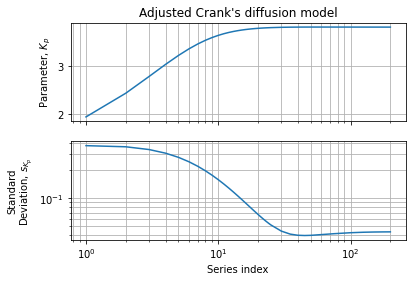

In [70]:
fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].semilogx(n, Kps, "-")
axes[1].loglog(n, sKps, "-")
axes[0].set_title("Adjusted Crank's diffusion model")
axes[0].set_ylabel("Parameter, $K_p$")
axes[1].set_ylabel("Standard\nDeviation, $s_{K_p}$")
axes[1].set_xlabel("Series index")
for i in range(2):
    axes[i].grid(which="both")

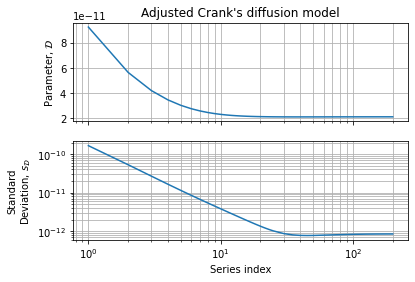

In [71]:
fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].semilogx(n, Ds, "-")
axes[1].loglog(n, sDs, "-")
axes[0].set_title("Adjusted Crank's diffusion model")
axes[0].set_ylabel("Parameter, $\mathcal{D}$")
axes[1].set_ylabel("Standard\nDeviation, $s_{\mathcal{D}}$")
axes[1].set_xlabel("Series index")
for i in range(2):
    axes[i].grid(which="both")

In [21]:
texp

array([1.00000000e+00, 2.06913808e+00, 4.28133240e+00, 8.85866790e+00,
       1.83298071e+01, 3.79269019e+01, 7.84759970e+01, 1.62377674e+02,
       3.35981829e+02, 6.95192796e+02, 1.43844989e+03, 2.97635144e+03,
       6.15848211e+03, 1.27427499e+04, 2.63665090e+04, 5.45559478e+04,
       1.12883789e+05, 2.33572147e+05, 4.83293024e+05, 1.00000000e+06])

In [22]:
rexp

array([0.97690042, 0.98524837, 0.97770071, 0.9615819 , 0.95447361,
       0.94827971, 0.90384175, 0.88139254, 0.84727166, 0.78269624,
       0.71873496, 0.64861892, 0.58147875, 0.50296883, 0.45500072,
       0.43489547, 0.44583273, 0.44571654, 0.43980288, 0.43671354])

In [65]:
@np.vectorize
def likelihood(K, D):
    return np.log(np.sum((CrankDiffusion(n=30).objective(texp, K, D) - rexp)**2))

In [12]:
Klin = np.logspace(-3, 3, 100)
Dlin = np.logspace(-13, -8, 100)

In [13]:
K, D = np.meshgrid(Klin, Dlin)

R = likelihood(K, D)

In [9]:
import pickle

with open("likelihood.pickle", "wb") as handler:
    pickle.dump(R, handler)

In [10]:
with open("likelihood.pickle", "rb") as handler:
    R = pickle.load(handler)

In [16]:
np.min(R), np.max(R)

(-6.971545481343595, 2.4088250159114053)

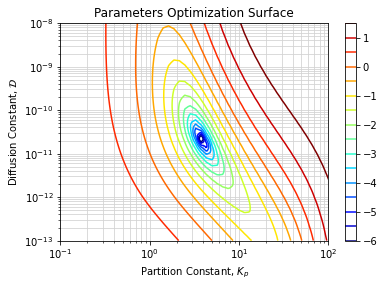

In [39]:
fig, axe = plt.subplots()
curves = axe.contour(K, D, R, np.arange(-6, 2, 0.5), cmap="jet")
axe.set_xscale("log")
axe.set_yscale("log")
#axe.clabel(curves, inline=True, fontsize=10)
axe.set_title("Parameters Optimization Surface")
axe.set_xlabel(r"Partition Constant, $K_p$")
axe.set_ylabel(r"Diffusion Constant, $\mathcal{D}$")
axe.set_xlim([1e-1, 1e2])
axe.grid(which="both", color="lightgray")
cbar = fig.colorbar(curves)